In [1]:
from s2_analytics.filters import PLAYLIST_CTF
from s2_analytics.collector.sqlite_collector import SqliteCollector
import pandas as pd
import seaborn as sns

from s2_analytics.importer import import_games

sqlite_collector = SqliteCollector("file::memory:").init()
import_games("logs_ranked/", period_days=90, processors=[sqlite_collector], game_filters=[PLAYLIST_CTF])
con = sqlite_collector.connection

# Ranked games

In [2]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query, con)

,first_game_start_time,last_game_start_time,games_count
0,2022-10-29 22:18:47,2023-01-21 23:18:15,1139


## Maps played

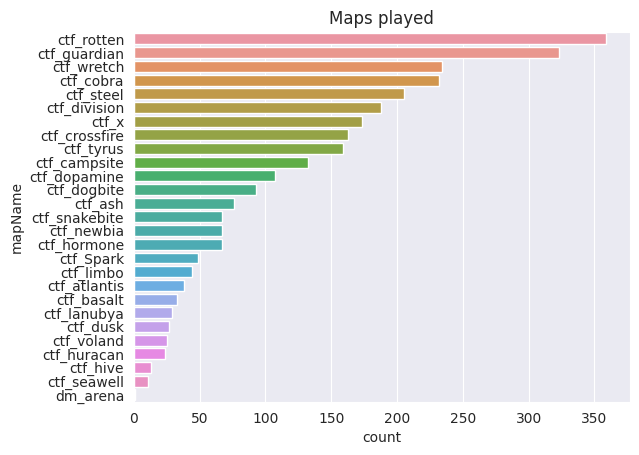

In [3]:
result6 = pd.read_sql_query("select mapName, count(1) as count from round group by mapName order by count desc", con)
sns.barplot(result6, y="mapName", x="count").set(title="Maps played")
pass

In [4]:
result6

,mapName,count
0,ctf_rotten,359
1,ctf_guardian,323
2,ctf_wretch,234
3,ctf_cobra,232
4,ctf_steel,205
5,ctf_division,188
6,ctf_x,173
7,ctf_crossfire,163
8,ctf_tyrus,159
9,ctf_campsite,132


## Average cap count per round

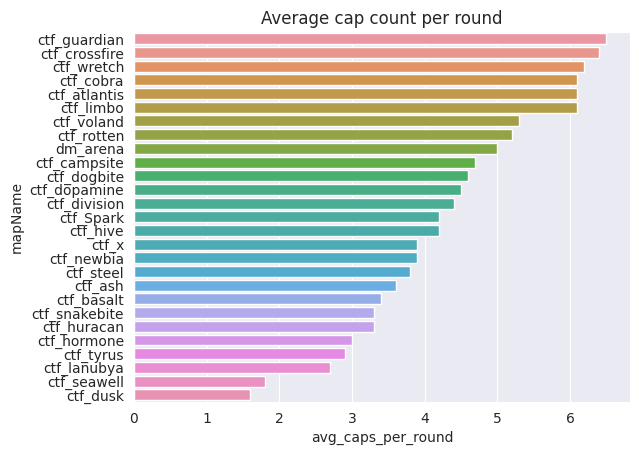

In [5]:
query = """
select distinct mapName,
round(1.0 *
    (select count(1) from event_cap c where r.mapName = c.mapName)/
    (select count(1) from round rr where r.mapName = rr.mapName), 1) avg_caps_per_round
from round r order by avg_caps_per_round desc;
"""
result7 = pd.read_sql_query(query, con)
sns.barplot(result7, y="mapName", x="avg_caps_per_round").set(title="Average cap count per round")
pass

In [6]:
result7

,mapName,avg_caps_per_round
0,ctf_guardian,6.5
1,ctf_crossfire,6.4
2,ctf_wretch,6.2
3,ctf_cobra,6.1
4,ctf_atlantis,6.1
5,ctf_limbo,6.1
6,ctf_voland,5.3
7,ctf_rotten,5.2
8,dm_arena,5.0
9,ctf_campsite,4.7


## Average rounds per game

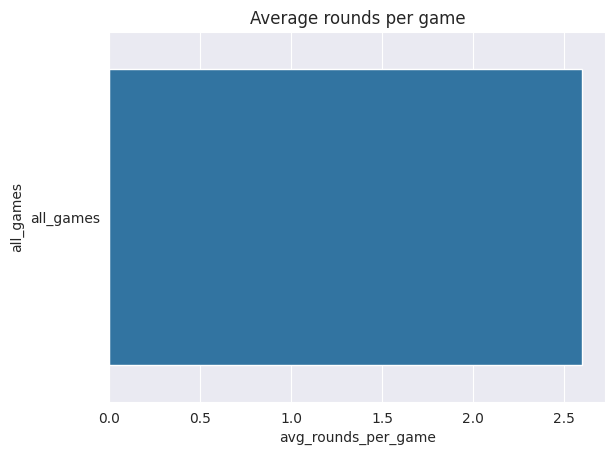

In [7]:
query = """select
"all_games" as all_games,
(select count(distinct game) from round) games_played,
(select count(1) from round) rounds_played,
round(1.0*(select count(1) from round)/(select count(distinct game) from round),1) avg_rounds_per_game
"""
result_rounds_per_game = pd.read_sql_query(query, con)
sns.barplot(result_rounds_per_game, y="all_games", x="avg_rounds_per_game").set(title="Average rounds per game")
pass

In [8]:
result_rounds_per_game

,all_games,games_played,rounds_played,avg_rounds_per_game
0,all_games,1132,2939,2.6


## Winning team

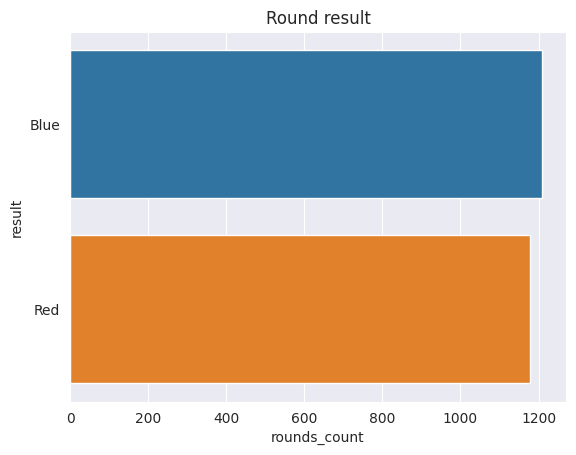

In [9]:
query = """
select result, count(1) rounds_count from round group by result;
"""
result_round_result = pd.read_sql_query(query, con)
sns.barplot(result_round_result, y="result", x="rounds_count", orient="h").set(title="Round result")
pass

## Rounds finished before time limit

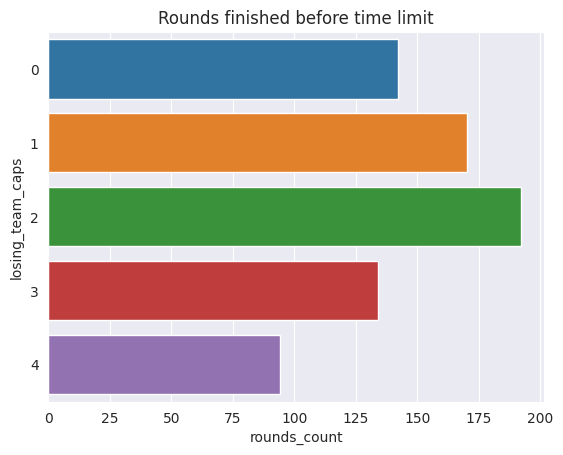

In [10]:
query = """
select
5 - abs(blueCaps - redCaps) losing_team_caps,
count(1) as rounds_count,
round(315 - (1.0*endTime - startTime)/1000,1) seconds_left_avg
from round where blueCaps = 5 or redCaps = 5 group by losing_team_caps;
"""
result_finished_before_limit = pd.read_sql_query(query, con)
sns.barplot(result_finished_before_limit, y="losing_team_caps", x="rounds_count", orient="h").set(title="Rounds finished before time limit")
pass

In [11]:
result_finished_before_limit

,losing_team_caps,rounds_count,seconds_left_avg
0,0,142,315.0
1,1,170,315.0
2,2,192,315.0
3,3,134,315.0
4,4,94,315.0


## Kills per weapon

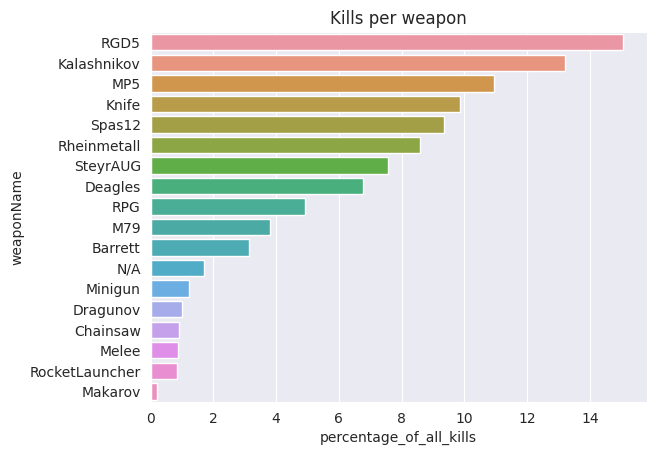

In [12]:
result8 = pd.read_sql_query(
    "select weaponName, round(100.0*count(1)/(select count(1) from event_kill ek),2) as percentage_of_all_kills from event_kill group by weaponName order by percentage_of_all_kills desc", con)
sns.barplot(result8,
            y="weaponName", x="percentage_of_all_kills").set(title="Kills per weapon")
pass

In [13]:
result8

,weaponName,percentage_of_all_kills
0,RGD5,15.05
1,Kalashnikov,13.21
2,MP5,10.93
3,Knife,9.86
4,Spas12,9.36
5,Rheinmetall,8.57
6,SteyrAUG,7.58
7,Deagles,6.78
8,RPG,4.93
9,M79,3.80
